Assignment on Graph Neural Networks in the course Advanced machine learning using neural networks (Chalmers and University of Gothenburg). 

The objective is to train a GNN that works as a graph classifier on the provided data. The data comes from simulations of a 25 qubit quantum memory (surface code) with individual error rates of 5% per cycle of measurements (see assignment text for a little more detail). Since the data consists of graphs with varying number of nodes the way to implement the classifier is to make a graph embedding, i.e. a mapping of each graph to a vector of fixed size. This can then be used for classification. The typical structure would be Graph data-> Graph (convolution or other) layers -> Pooling -> Dense classifier. 

For this data the classification accuracy of the standard graph algorithm based decoder (minimum weight perfect matching) is 0.983. It may be hard to reach this without an even larger dataset, but it can serve as a target. Anything above an accuracy of 0.95 is acceptable. (This means that the quantum memory has a lower failure rate than the individual qubits, which is set at 5% to generate the data.)

The following shows how to load the data if it's available in your Google drive

In [ ]:
#Runtime: 30s

from google.colab import drive
drive.mount('/content/drive')
import os
import torch
os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#Runtime: 4 minutes
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
import networkx as nx
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
dataset = torch.load('/content/drive/MyDrive/graph_data_decoding_2023.pt')

Number of graphs: 1000000
Some properties of a graph in the dataset:

Data(x=[5, 4], edge_index=[2, 20], edge_attr=[20, 1], y=[1, 2])
Number of nodes: 5
Number of edges: 20
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4
tensor([1.]) tensor([0.])


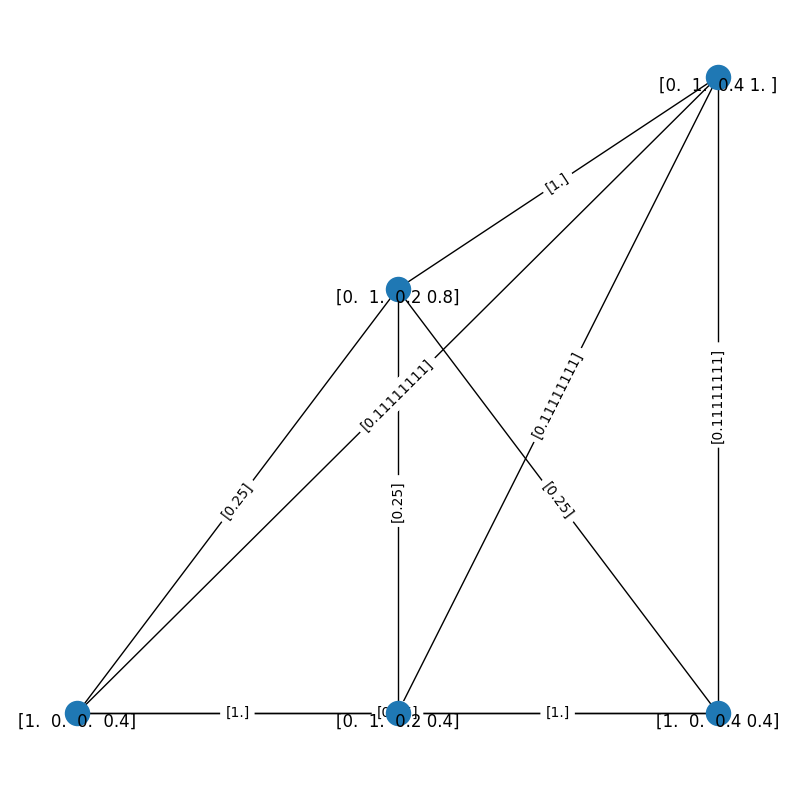

In [ ]:

print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')
data = dataset[20]  # Get one data point.

print('Some properties of a graph in the dataset:')
print()

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')

label=data.y
label_X=label[:,0]
label_Z=label[:,1]
print(label_X,label_Z)
#The data point dataset[20] is thus in class X


edge_index = data.edge_index.t()
edge_index=edge_index.numpy()
feature=data.x.numpy()
edge=data.edge_attr.numpy()

graph = dataset[20]
g = utils.to_networkx(graph, to_undirected=True)
positions = {}
label_positions = {}
node_labels = {}
edge_labels={}
x = graph.x

for i in range(x.shape[0]):
    positions[i] = np.array([x[i, 2], x[i, 3]])
    label_positions[i] = np.array([x[i, 2], x[i, 3]])
    node_labels[i] = np.array([x[i, 0], x[i, 1], x[i, 2], x[i, 3]])
for i in range(edge_index.shape[0]):
    edge_labels[(edge_index[i,0],edge_index[i,1])]=edge[i]
    
fig, ax = plt.subplots(figsize = (10, 10))
nx.draw_networkx(g, ax=ax, pos = positions, labels = node_labels, with_labels = False)
nx.draw_networkx_labels(g, ax=ax, pos = label_positions, labels = node_labels, verticalalignment= 'top')
nx.draw_networkx_edge_labels(g,ax=ax,  pos = positions,edge_labels=edge_labels)
ax.axis('off')

# split the dataset into test and validation:
num_samples = len(dataset)
train_data = dataset[int(.05 * num_samples ) :] # 95% train
test_data = dataset[: int(.05 * num_samples )] # 5% test
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

In [ ]:
#Runtime: 0s
from IPython.display import Javascript  # Restrict height of output cell.
from sklearn.manifold import TSNE
import torch.nn as nn

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
num_classes = 4

#Network layout, 3 conv layers give slightly higher accuracy, but is slower.
#The Multi-layer perceptron (MLP) are the final 3 linear layers
#Dropout is added after the relu() activation functions to reduce overfitting

#It's very important to include the edge_weight = edge_attr parameter for the Convolutional layers!!

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN,self).__init__()
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels*2)
        self.conv3 = GCNConv(hidden_channels*2, hidden_channels*2)

        self.lin1 = Linear(hidden_channels*2, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, 2)

    def forward(self, x, edge_index,batch,edge_attr):

        x = self.conv1(x,edge_index,edge_weight = edge_attr)
        x = x.relu()
        x = F.dropout(x,p=0.5,training =self.training)
        x = self.conv2(x,edge_index,edge_weight = edge_attr)
        x=  x.relu()
        x = F.dropout(x,p=0.5,training =self.training)

       #commented out for performance, include these if you want.
       # x = self.conv3(x,edge_index,edge_weight = edge_attr)
       # x = x.relu()
       # x = F.dropout(x,p=0.5,training =self.training)

        x = global_mean_pool(x,batch) #Avg pooling of the entire batch
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        return x
        
model = GCN(hidden_channels=32)
model.eval()
out = model(data.x, data.edge_index,data.batch,data.edge_attr)



<IPython.core.display.Javascript object>

torch.Size([1000, 2])


# TRAINING

In [ ]:
#Runtime ~ 10 minutes

#Parameters:
hidden_channels = 8 #16 or 32 can be good as well
learn_rate = 0.025
####################


model = GCN(hidden_channels=hidden_channels)
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
criterion = torch.nn.CrossEntropyLoss()   

for epoch in range(10):
  model.train()
  for data in train_loader:
      label = data.y
      out = model(data.x, data.edge_index,data.batch,data.edge_attr)
      loss = criterion(out,label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()




# TESTING

In [ ]:
#Runtime: 5s

#Compare the predicted outputs to the labels 
model.eval()
correct_counter = 0
for data in test_loader:     
  labels = data.y  #Labels for the dataset, 1000x2

  label_X = labels[:,0]
  label_Z = labels[:,1]

  out = model(data.x, data.edge_index,data.batch,data.edge_attr) #Outputs a 1000x2 matrix with bit pairs as entries
  predicted_output =  (torch.sgn(out) +1)/2                      #convert to 0/1 instead of -1/1 

  for i in range(len(predicted_output)):
    if predicted_output[i,0] == label_X[i] and  predicted_output[i,1] == label_Z[i]: 
      correct_counter += 1
      continue

    if predicted_output[i,0] == label_X[i] or predicted_output[i,1] == label_Z[i]:
      correct_counter   +=  1


ratio = correct_counter / len(test_loader.dataset)
print("Accuracy = " + str(ratio))




Accuracy = 0.96772
